In [4]:
!pip install biopython


In [4]:

!pip install biopython tensorflow scikit-learn matplotlib


  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
    --------------------------------------- 0.3/10.7 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.7 MB 2.0 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/10.7 MB 2.2 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/10.7 MB 2.3 MB/s eta 0:00:05
   ------- -------------------------------- 2.1/10.7 MB 2.2 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/10.7 MB 2.2 MB/s eta 0:00:04
   ----------- ---------------------------- 3.1/10.7 MB 2.3 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/10.7 MB 2.2 MB/s eta 0:00:04
   -------------- ------------------------- 3.9/10.7 MB 2.2 MB/s eta 0:00:04
   ---------------- -------

In [6]:
enhancer_bed = pd.read_csv("F5.hg38.enhancers.bed", sep="\t", header=None)
print(enhancer_bed.shape)
enhancer_bed.head()


(63285, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,chr10,100006233,100006603,chr10:100006233-100006603,35,.,100006509,100006510,"0,0,0",2,"218,34","0,336"
1,chr10,100008181,100008444,chr10:100008181-100008444,101,.,100008274,100008275,"0,0,0",2,"32,108","0,155"
2,chr10,100014348,100014634,chr10:100014348-100014634,3,.,100014546,100014547,"0,0,0",2,"112,1","0,285"
3,chr10,100020065,100020562,chr10:100020065-100020562,211,.,100020344,100020345,"0,0,0",2,"210,148","0,349"
4,chr10,100043485,100043744,chr10:100043485-100043744,3,.,100043656,100043657,"0,0,0",2,"86,1","0,258"


In [7]:
# Step 1 Extracting enhancer sequences 
import pandas as pd

# Load BED file
enhancer_bed = pd.read_csv("F5.hg38.enhancers.bed", sep="\t", header=None)
enhancer_bed.columns = [
    "chr", "start", "end", "id", "score", "strand",
    "thickStart", "thickEnd", "itemRgb", "blockCount", "blockSizes", "blockStarts"
]
enhancer_bed.head()


,chr,start,end,id,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr10,100006233,100006603,chr10:100006233-100006603,35,.,100006509,100006510,"0,0,0",2,"218,34","0,336"
1,chr10,100008181,100008444,chr10:100008181-100008444,101,.,100008274,100008275,"0,0,0",2,"32,108","0,155"
2,chr10,100014348,100014634,chr10:100014348-100014634,3,.,100014546,100014547,"0,0,0",2,"112,1","0,285"
3,chr10,100020065,100020562,chr10:100020065-100020562,211,.,100020344,100020345,"0,0,0",2,"210,148","0,349"
4,chr10,100043485,100043744,chr10:100043485-100043744,3,.,100043656,100043657,"0,0,0",2,"86,1","0,258"


In [10]:
# Step 2: Extract Enhancer Sequences from hg38.fa
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

# Load hg38 genome FASTA
fasta_path = "hg38.fa"
genome = SeqIO.to_dict(SeqIO.parse(fasta_path, "fasta"))

# Function to extract sequences
def get_sequence(chrom, start, end):
    try:
        seq = genome[chrom].seq[int(start):int(end)]
        return str(seq)
    except KeyError:
        return None

# Extract sequences
enhancer_bed["sequence"] = enhancer_bed.apply(
    lambda row: get_sequence(row["chr"], row["start"], row["end"]), axis=1
)

# Drop any failed extractions (if any chromosomes weren't found)
enhancer_bed = enhancer_bed.dropna(subset=["sequence"])

# Save to FASTA
records = [
    SeqRecord(seq=Seq(row["sequence"]), id=f"enh_{i}", description="")  # wrap in Seq()
    for i, row in enhancer_bed.iterrows()
]

SeqIO.write(records, "enhancer_sequences.fasta", "fasta")


63285

In [15]:

# Determing enhancer length
print(enhancer_bed.columns)

enhancer_bed["length"] = enhancer_bed["end"] - enhancer_bed["start"]
enhancer_bed["length"].describe()



Index(['chr', 'start', 'end', 'id', 'score', 'strand', 'thickStart',
       'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts',
       'sequence'],
      dtype='object')


count    63285.000000
mean       294.565316
std        170.459421
min          2.000000
25%        183.000000
50%        282.000000
75%        375.000000
max       2804.000000
Name: length, dtype: float64

In [16]:
# Generate Non-Enhancer Sequences (Random Genomic Regions)
import random

# Set of valid chromosomes to sample from
valid_chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

# Load genome sizes (simplified here — ideally use actual chromosome sizes)
genome_sizes = {
    "chr1": 248956422, "chr2": 242193529, "chr3": 198295559, "chr4": 190214555,
    "chr5": 181538259, "chr6": 170805979, "chr7": 159345973, "chr8": 145138636,
    "chr9": 138394717, "chr10": 133797422, "chr11": 135086622, "chr12": 133275309,
    "chr13": 114364328, "chr14": 107043718, "chr15": 101991189, "chr16": 90338345,
    "chr17": 83257441, "chr18": 80373285, "chr19": 58617616, "chr20": 64444167,
    "chr21": 46709983, "chr22": 50818468, "chrX": 156040895, "chrY": 57227415
}

# Get enhancer lengths
lengths = enhancer_bed["length"].values

# Generate random non-enhancer regions
non_enhancers = []

for length in lengths:
    while True:
        chrom = random.choice(valid_chromosomes)
        max_start = genome_sizes[chrom] - length - 1
        start = random.randint(0, max_start)
        end = start + length
        non_enhancers.append((chrom, start, end))
        break  # You could add overlap checks here if needed

# Convert to DataFrame
import pandas as pd
negatives_df = pd.DataFrame(non_enhancers, columns=["chr", "start", "end"])
negatives_df["id"] = [f"neg_{i}" for i in range(len(negatives_df))]

negatives_df.head()


,chr,start,end,id
0,chr20,28384287,28384657,neg_0
1,chr12,106421398,106421661,neg_1
2,chr13,64848115,64848401,neg_2
3,chr4,58537863,58538360,neg_3
4,chr11,133939503,133939762,neg_4


In [17]:
# extract FASTA Sequences for Non-Enhancers
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from collections import defaultdict

# Load hg38 genome (fasta) into dictionary
genome_dict = SeqIO.to_dict(SeqIO.parse("hg38.fa", "fasta"))

# Function to extract sequence for each non-enhancer
negative_records = []

for i, row in negatives_df.iterrows():
    chrom = row["chr"]
    start = int(row["start"])
    end = int(row["end"])

    if chrom in genome_dict:
        seq = genome_dict[chrom].seq[start:end]
        record = SeqRecord(Seq(str(seq)), id=f"neg_{i}", description="")
        negative_records.append(record)

# Save to FASTA
from Bio import SeqIO
SeqIO.write(negative_records, "negative_sequences.fasta", "fasta")

# Print confirmation
print(f"Saved {len(negative_records)} negative sequences to 'negative_sequences.fasta'")


Saved 63285 negative sequences to 'negative_sequences.fasta'


In [18]:
# Combine and Prepare Data for Model Input
from Bio import SeqIO
import numpy as np
import random

# Load both sets
enhancer_records = list(SeqIO.parse("enhancer_sequences.fasta", "fasta"))
negative_records = list(SeqIO.parse("negative_sequences.fasta", "fasta"))

# Assign labels
sequences = []
labels = []

for record in enhancer_records:
    sequences.append(str(record.seq).upper()[:200])  # standardizing length
    labels.append(1)

for record in negative_records:
    sequences.append(str(record.seq).upper()[:200])
    labels.append(0)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Shuffle dataset (very important!)
combined = list(zip(sequences, labels))
random.shuffle(combined)
sequences, labels = zip(*combined)

# Convert to arrays again
sequences = np.array(sequences)
labels = np.array(labels)

print(f"✅ Combined Dataset: {len(sequences)} sequences")
print(f"First 5 Labels: {labels[:5]}")


✅ Combined Dataset: 126570 sequences
First 5 Labels: [0 1 1 1 1]


In [19]:
# One HOT encoding
def one_hot_encode(sequences):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    encoded = np.zeros((len(sequences), 200, 4), dtype=np.float32)

    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base in mapping:
                encoded[i, j, mapping[base]] = 1.0
    return encoded

# Apply encoding
X = one_hot_encode(sequences)
y = labels

print(f"✅ One-hot encoded shape: {X.shape}")
print(f"First label set: {y[:5]}")


✅ One-hot encoded shape: (126570, 200, 4)
First label set: [0 1 1 1 1]


In [20]:
# Build and Train
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# Split the dataset 
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")

# Define the CNN model 
model = Sequential([
    Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(200, 4)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=10, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
# Train the model 
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    verbose=1
)


Train: (101256, 200, 4), Validation: (25314, 200, 4)


C:\Users\Dell\miniconda3\envs\bioinformatics\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 191, 64)             │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 86, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         352,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437,057 (1.67 MB)

 Trainable params: 437,057 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.5936 - loss: 0.6668 - val_accuracy: 0.6579 - val_loss: 0.6185
Epoch 2/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6519 - loss: 0.6222 - val_accuracy: 0.6849 - val_loss: 0.5903
Epoch 3/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6741 - loss: 0.5956 - val_accuracy: 0.6983 - val_loss: 0.5772
Epoch 4/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6900 - loss: 0.5801 - val_accuracy: 0.7076 - val_loss: 0.5660
Epoch 5/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.7036 - loss: 0.5676 - val_accuracy: 0.7194 - val_loss: 0.5540
Epoch 6/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.7114 - loss: 0.5577 - val_accuracy: 0.7062 - val_loss: 0.5559
Epoch 7/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.7157 - loss: 0.5501 - val_accuracy: 0.7140 - val_loss: 0.5460
Epoch 8/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.7219 - loss: 0.5416 - 

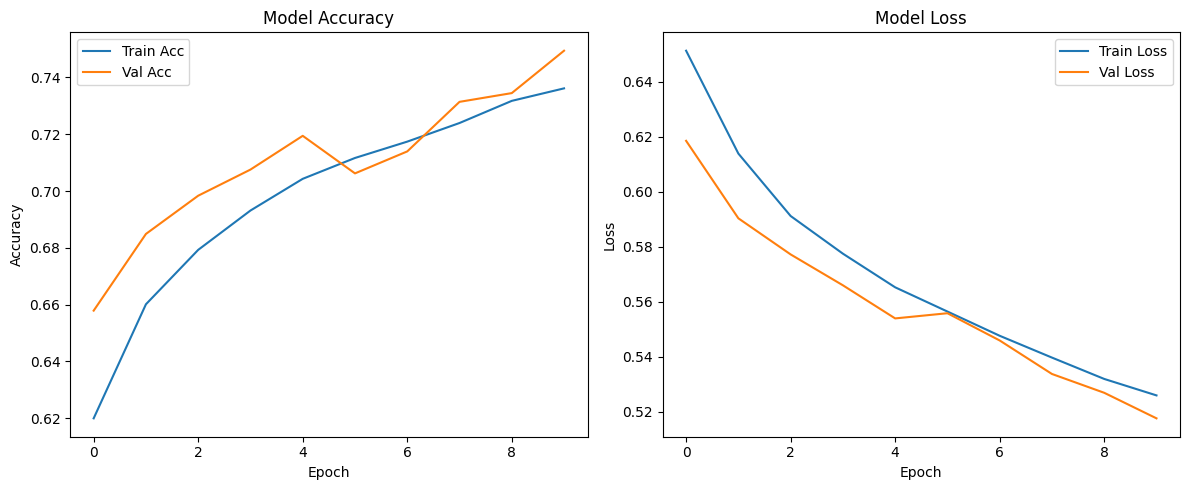

In [21]:
# Evaluate model performace 
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Evaulate on validation set 
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


✅ Validation Accuracy: 0.7494
📉 Validation Loss: 0.5177


In [23]:
# Save the model
model.save("enhancer_classifier_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!
